## Accelerating Vectors

This is part of pyxem, Hyperspy, py4DSTEM, xarray, etc., which is always a bit slower than it should be.  It's quite a shame, but it's a fairly difficult problem to solve. 

Let's start trying to chip away at the problem a little bit :) From the perspective of the entire field, this is another place where there is a lot of potential for future code development and having an underlying language for communicating between packages would be helpful. A lot of work was done with the [Ragged](https://github.com/scikit-hep/ragged) package but something like that requires a fair bit of devoted efforts.

I'd love to see this as something that our community takes upon itself to solve!!!

For now my challenge to you is "How fast can you create a virtual image from a set of vectors or a 4D Dataset?" 

~50 ms is about what it take to make something "Live"

## Making a Test dataset:

A lot of times when I'm developing something I like to make a [toy dataset](https://pyxem.readthedocs.io/en/stable/reference/generated/pyxem.data.html#module-pyxem.data) to help me.  These are often good for creating tests and making sure that things work as intended.  They also help when writing examples as Read the Docs tends to complain about downloading from zenodo. Usually I try to make a toy dataset that mirrors a real dataset.  In this case I have a layered multiphase sample with an amorphous interface. 

I actually just asked Chat GPT this:


```
Make a toy 4d stem dataset of a layered sample with amorphous layers between the layers.  Each layer should have different in plane orientations within the layer.  

Start by making a labeled image, then use diffsims to simulate one orientation.  Rotate that orientation to make the different orientations.

The 4D STEM dataset should be a dask array, and you should also output the list of vectors at each point
```

It did really well at the first part... Not so well at the second part...

In [1]:
from pyxem.data.simulated_strain import create_diffraction_pattern
from pyxem.data import si_phase
from diffsims.generators.simulation_generator import SimulationGenerator
from orix.quaternion import Rotation, Orientation
from pyxem.signals import DiffractionVectors,ElectronDiffraction2D
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import hyperspy.api as hs
from skimage.draw import disk
from scipy.ndimage import gaussian_filter

def create_seed_based_labeled_image(shape=(256, 256),
                                    n_layers=10,
                                    grains_per_layer=4,
                                    amorphous_thickness=4,
                                    seed=42):
    """
    Created a labeled image of a bunch of grains.  This is used to create the dask 4D dataset. 
    """
    np.random.seed(seed)
    img = np.full(shape, fill_value=-1, dtype=int)
    height, width = shape
    layer_thickness = (height - (n_layers - 1) * amorphous_thickness) // n_layers
    label = 1

    for i in range(n_layers):
        start_y = i * (layer_thickness + amorphous_thickness)
        end_y = start_y + layer_thickness

        # Generate seed points within the current layer
        seeds = []
        for _ in range(grains_per_layer):
            x = np.random.randint(0, width)
            y = np.random.randint(start_y, end_y)
            seeds.append((y, x))

        # Create a KDTree for efficient nearest neighbor search
        seeds_arr = np.array(seeds)
        tree = cKDTree(seeds_arr)

        # For every pixel in the current layer, find nearest seed
        for y in range(start_y, end_y):
            for x in range(width):
                dist, idx = tree.query((y, x))
                img[y, x] = label + idx

        label += grains_per_layer  # increment label counter

    return img
    
def create_random_diffraction_patterns(phase,
                                       num_dps, 
                                       shape = (256, 256),
                                      disk_radius=5, 
                                      num_electrons=None):
    gen = SimulationGenerator(precession_angle=1)
    rotations = Rotation.random(num_dps)
    sim = gen.calculate_diffraction2d(
        phase=si_phase(), rotation=rotations, reciprocal_radius=1.5, max_excitation_error=0.1
    )
    
    patterns = [create_diffraction_pattern(sim.irot[i],shape=shape, radius=disk_radius, num_electrons=num_electrons) for i in range(num_dps)]
    x_y_iten_vectors = [np.hstack((s.data[:,:2],s.intensity[:, None]))  for s in sim.coordinates]
    x_y_iten_vectors.append(np.array([[0,0,1]])) # last one is just nothing
    am_pattern = np.zeros(shape)
    ccin, rrin = disk(np.array(shape)//2, radius=shape[0]//6)
    ccout, rrout = disk(np.array(shape)//2, radius=shape[0]//4)
    am_pattern[ccout,rrout] = 1
    am_pattern[ccin,rrin] = 0
    cc, rr = disk(np.array(shape)//2, radius=disk_radius)
    am_pattern= gaussian_filter(am_pattern, sigma=2)
    am_pattern[cc,rr]=1

    patterns.append(am_pattern)
    return patterns, x_y_iten_vectors


def create_diffraction_vectors(labeled_image, vectors):
    new_vectors= np.empty(shape=labeled_image.shape, dtype=object)
    for ind in np.ndindex(labeled_image.shape):
        new_vectors[ind] = vectors[labeled_image[ind]]
    new_vectors = DiffractionVectors(new_vectors, units=["A^-1","A^-1","a.u"],column_names=["x", "y", "intensity"] )
    return new_vectors
    
def generate_patterns_from_labels(label_block, patterns):
    shape = label_block.shape + patterns[0].shape
    output_block = np.empty(shape=shape)
    for ind in np.ndindex(label_block.shape):
        output_block[ind] = patterns[label_block[ind]]
    return output_block


def create_4dstem_data_set(labeled_image, patterns, chunks=(16, 16)):
    label_dask = da.from_array(labeled_image, chunks=chunks)
    # Map blocks: output has shape (Y, X, Ny, Nx)
    data4d = label_dask.map_blocks(
    generate_patterns_from_labels,
    dtype=np.float32,
    patterns = patterns,
    drop_axis=[],
    new_axis=[2, 3],  # add diffraction dimensions
    chunks =(16, 16)+patterns[0].shape,
    )
    data4d = ElectronDiffraction2D(data4d).as_lazy()
    data4d.axes_manager.signal_axes.set(scale=0.01, units="A^-1", name=["kx", "ky"])
    data4d.axes_manager.navigation_axes.set(scale=1, units="nm", name=["x", "y"])

    return data4d

def layered_si(navigation_shape=(128,128),
               signal_shape=(128,128), 
               n_layers=10,
               grains_per_layer=4,
               amorphous_thickness=4,
               phase=None, 
               chunks =(16, 16),
               disk_radius = 7,
               num_electrons=None, 
               seed=42):
    if phase is None:
        phase= si_phase()
    img = create_seed_based_labeled_image(shape=navigation_shape,
                                    n_layers=n_layers,
                                    grains_per_layer=grains_per_layer,
                                    amorphous_thickness=amorphous_thickness,
                                    seed=seed)
    
    patterns, vectors = create_random_diffraction_patterns(phase=phase,
                                                           num_dps = np.max(img)+1, 
                                                           shape = signal_shape,
                                                          disk_radius=disk_radius,
                                                          num_electrons=num_electrons)
    dvs = create_diffraction_vectors(img, vectors)
    dps = create_4dstem_data_set(img, patterns=patterns, chunks=chunks)
    dps.navigator = hs.signals.Signal2D(img)
    return dvs, dps

In [2]:
dv, signal = layered_si(navigation_shape=(512,512), num_electrons=1E5)

In [3]:
%matplotlib ipympl
signal.plot(vmax="99th")

I hope that the code above is helpful. It is a good way to make a dataset that you can scale to be arbitarily large.  For me this is super nice for making examples and it (kind of) looks like it could be almost real...

## Let's get into it:

First we should try to use awkard array to solve this problem. This is our bench mark. This should be fairly fast. Under the hood awkward array is __vectorized__ so it should be fairly similar speed to numpy. 

In [4]:
import awkward as ak
import numpy as np
num = np.array([[int(len(v)) for v in vv ]for vv in dv.data])
ar = np.vstack([v for vv in dv.data for v in vv ])
a = ak.Array(ar)
awk_vectors = ak.unflatten(ak.unflatten(a, num.flatten()), num.shape[1])

def slice_ragged_vectors(vectors, roi):
    center = np.array([roi.cx, roi.cy, 0 ])[None, None,None] # Don't change the intensity
    shifted_vectors =  vectors - center
    distance = np.sqrt((shifted_vectors[:,:,:,0]**2+shifted_vectors[:,:,:,1]**2))
    is_in = ak.values_astype(distance<c.r, int)
    is_in = ak.values_astype(distance>c.r_inner, int) *is_in
    virtual_img = is_in  * vectors[:,:,:,2]
    virtual_img = np.sum(virtual_img, axis=-1)
    return hs.signals.Signal2D(virtual_img.to_numpy())

In [5]:
c = hs.roi.CircleROI(r=.4, cx=0, cy=0)

In [6]:
%%timeit 
slice_ragged_vectors(awk_vectors, c)

2.72 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Ouch...

2.69 seconds isn't a long time but it's a far cry from my dreams of an interactive and live virtual image.  Maybe we can optimize this a little bit more. There are lots of tools for profiling python code, I quite like ``pyinstrument``

In [7]:
%load_ext pyinstrument

<Signal2D, title: , dimensions: (|512, 512)>

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:30:05  Samples:  106
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.691     CPU time: 2.703
/   _/                      v5.0.0

Cell [8]

2.691 <module>  ..\AppData\Local\Temp\ipykernel_15224\2735330094.py:1
`- 2.691 slice_ragged_vectors  ..\AppData\Local\Temp\ipykernel_15224\2599733351.py:8
   |- 1.498 Array.func  awkward\_operators.py:50
   |     [37 frames hidden]  awkward, <built-in>, numpy
   |        1.050 Numpy._apply_ufunc_nep_50  awkward\_nplikes\array_module.py:229
   |        `- 1.023 [self]  awkward\_nplikes\array_module.py
   |- 1.058 Array.__getitem__  awkward\highlevel.py:666
   |     [15 frames hidden]  awkward
   |- 0.055 Array.__array_function__  awkward\highlevel.py:1596
   |     [9 frames hidden]  awkward
   |- 0.039 Array.__array_ufunc__  awkward\highlevel.py:1527
   |     [15 frames hidden]  awkward
   `- 0.027 dispatch  awkward\_dispatch.py:35
         [8 frames hidden]  awkward, <built-in>
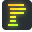

In [8]:
%%pyinstrument
slice_ragged_vectors(awk_vectors, c)

In [9]:
256*256*400/512/512

100.0

## So our baseline is 2.7 seconds

Most of that time is being spent trying to find the distance and select which points are inside.  It might seem fast but we are still scaling linearly with the number of probe positions. If you tested this with a smaller 128 x 128 probe position dataset you might think that .16 seconds is pretty good and seems pretty fast.

a 2k x 2k 4D STEM scan is 16 times larger so that's ~43 seconds which is annoying.... 


For a 256 x 256 x 400 5D STEM scan is 100 times larger or is ~270 seconds... Which is not live.

## Cheating is (almost) always the answer...

With making (any) code truly efficient, most likely you need to cheat :) 


- In the orientation mapping code in pyxem we transform to polar coordinates reducing the total number of patterns we need to match
- In the azimuthal integration code we first create a list of all of the polar bins, the pixels which contribute to each bin and then the fraction of that pixel inside the bin.

If you are going to reuse anything, compute it once and share it!  Electron microscopy is a little different than most  because you tend to have many many repetitions of the same thing. A lovely way to handle this is with a KD Tree. 

<img src="KDTree.JPG" alt="KDTree">

In [10]:
from scipy.spatial import KDTree

## Lets Try It!

In [11]:
flat_vectors = dv.flatten_diffraction_vectors()

In [13]:
flat_vectors.data[:,2:4]

array([[ 1.06148287,  0.69485614],
       [ 1.3043195 , -0.44116304],
       [ 1.34678406,  0.28984135],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [14]:
# build the tree, this takes a little bit
kdtree = KDTree(flat_vectors.data[:,2:4]) # [x, y, kx, ky, intensity]

In [15]:
%%timeit
# time to get all of the points within 0.2 A^-1
indexes = kdtree.query_ball_point([0,0], r=0.2, workers=1) 

31.8 ms ± 783 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
indexes = kdtree.query_ball_point([0,0], r=0.2, workers=1) 

So that is fast :) But how do we make that back into an image??

## Trying something new....

Let's write this function, but the for loop in it is going to be slooowwww....

In [23]:
num_vectors_per_probe = [len(col) for row in dv.data for col in row]
end_index_probe = np.cumsum(num_vectors_per_probe)

In [24]:
indexes = kdtree.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_vectors.data[indexes, 4]
virtual_image  = np.empty(len(end_index_probe))
for inten, ind in zip(intensities,indexes) :
    red_index =  np.searchsorted(end_index_probe, ind)
    virtual_image[red_index] += inten

virtual_image = virtual_image.reshape(dv.data.shape)

In [25]:
%%timeit
indexes = kdtree.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_vectors.data[indexes, 4]
virtual_image  = np.empty(len(end_index_probe))
for inten, ind in zip(intensities,indexes) :
    red_index =  np.searchsorted(end_index_probe, ind)
    virtual_image[red_index] += inten

virtual_image = virtual_image.reshape(dv.data.shape)

1.27 s ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Well...

We are about 2 times faster which is nice but anytime you have a for loop in python it is going to be slow.  Maybe we can speed this up a little bit using numpy a bit better 

In [26]:
# lets pre calculate which flat in each vector goes along with.
inds = np.arange(len(num_vectors_per_probe))
probe_ind_for_each_vector = np.repeat(inds, num_vectors_per_probe)

In [27]:
%%timeit
indexes = kdtree.query_ball_point([.4,.4], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_vectors.data[indexes, 4]
reduced_probe_ind = probe_ind_for_each_vector[indexes]
virtual_image = np.bincount(reduced_probe_ind,
                            weights=intensities,
                            minlength=len(num_vectors_per_probe))
virtual_image = virtual_image.reshape(dv.data.shape)

47.9 ms ± 549 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
indexes = kdtree.query_ball_point([.4,.4], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_vectors.data[indexes, 4]
reduced_probe_ind = probe_ind_for_each_vector[indexes]
virtual_image = np.bincount(reduced_probe_ind,
                            weights=intensities,
                            minlength=len(num_vectors_per_probe))
virtual_image = virtual_image.reshape(dv.data.shape)

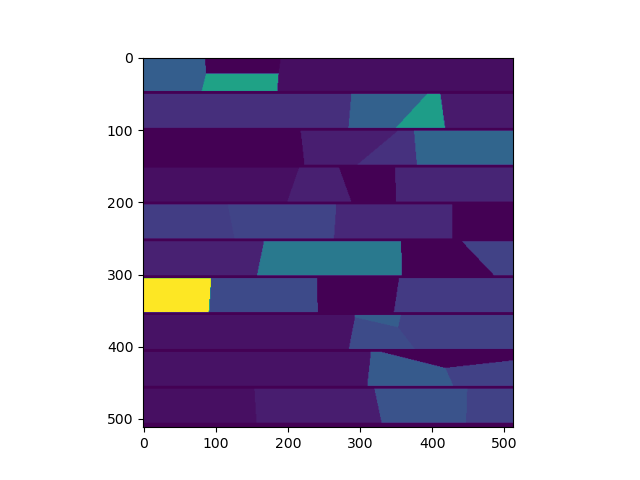

In [29]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(virtual_image)

# We are down from around 2.7 seconds to about 50 ms

And all we have done is exploit numpy and some fun weird math with KD Trees.  We probably aren't going to go faster that a KD-Tree (although maybe there is something like a Quad tree that might be faster, considering our vectors are based on an x-y graph.  

Let's take things to numba... 

In [30]:
from numba import njit

@njit
def accumulate_virtual_image(indexes, vector_array, all_indexes, num_probes):
    virtual_image = np.zeros(num_probes, dtype=np.float64)

    for i in range(len(indexes)):
        ind = indexes[i]
        intensity = vector_array[ind, 2] # x, y, intensity
        red_index = all_indexes[ind]
        virtual_image[red_index] += intensity

    return virtual_image

In [31]:
indexes = kdtree.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1

In [32]:
%%timeit
arr = accumulate_virtual_image(indexes,
                               flat_vectors.data[:,2:],
                               probe_ind_for_each_vector, 
                               num_probes=len(num_vectors_per_probe)).reshape(dv.data.shape)

793 ms ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Now what...

Unfortunately (fortunately??), ``numpy`` is pretty hard to beat these days even if you start writing cython code bincount is probably as good as you are going to get. 

If we wanted to make the numba code faster we could do a better job with our for loop. Seperating the accumlation for each pixel onto a seperate thread etc.  Most likely we are going to spend a lot of time to read numpy like performance....

Maybe we just stop... and see how good we are doing???

In [50]:
def kd_tree_virtual_image(kd_tree, flat_vector_array, all_indexes, roi, shape):
    center = np.array([roi.cy, roi.cx])
    indexes = kd_tree.query_ball_point(center, r=roi.r, workers=1) # time to get all of the points within 0.2 A^-1
    intensities= flat_vector_array[indexes, 2]
    red_indices = all_indexes[indexes]
    virtual_image = np.bincount(red_indices, weights=intensities, minlength=np.prod(shape))
    virtual_image = virtual_image.reshape(shape)
    return hs.signals.Signal2D(virtual_image)

In [51]:
shape = dv.data.shape
vectors_per_probe_position = [len(col)  for row in dv.data for col in row]
flat_index_of_vector = np.repeat(np.arange(len(vectors_per_probe_position)),
                                 vectors_per_probe_position)
flat_vectors= dv.flatten_diffraction_vectors()

In [52]:
flat_vectors.data[:, 2:5]

array([[  1.06148287,   0.69485614,  27.69868842],
       [  1.3043195 ,  -0.44116304, 174.44405988],
       [  1.34678406,   0.28984135,  93.65410467],
       ...,
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,   0.        ,   1.        ]])

In [61]:
from scipy.spatial import KDTree
import hyperspy.api as hs
def plot_vectors_kd(flat_vectors,signal, shape, flat_index_of_vector):
    tree = KDTree(flat_vectors.data[:, 2:4])
    roi = hs.roi.CircleROI(r=0.2)
    signal.plot()
    roi.add_widget(signal, axes=(2,3))
    virtual_img = hs.interactive(kd_tree_virtual_image, 
                   kd_tree = tree,
                   flat_vector_array=flat_vectors.data[:,2:5],
                   all_indexes = flat_index_of_vector, 
                   roi = roi, 
                   shape=shape,
                   event=roi.events.changed,)
    virtual_img.plot()

In [63]:
roi = hs.roi.CircleROI(r=0.2)


In [57]:
%matplotlib qt
plot_vectors_kd(flat_vectors,
                signal=signal,
                shape=shape,
                flat_index_of_vector=flat_index_of_vector)

### Thoughts and takeaways:

0.05 seconds for a virtual image that is 512x 512 is pretty good although if we try to move to a 2k x 2k image we get some lag.  

Can we push it further??? Can you :)  One that that is coming soon is a cupy implementation of KD Trees.  That is very exciting and should help tremendously with speed!

The next step is going to be adding this functionality into pyxem so that it is easily useable!

Let's start to think about how that might look???

In [58]:
dv, signal = layered_si(navigation_shape=(2048,2048), num_electrons=1E5)

In [59]:
shape = dv.data.shape
vectors_per_probe_position = [len(col)  for row in dv.data for col in row]
flat_index_of_vector = np.repeat(np.arange(len(vectors_per_probe_position)),
                                 vectors_per_probe_position)
flat_vectors= dv.flatten_diffraction_vectors()

In [62]:
plot_vectors_kd(flat_vectors,
                signal=signal,
                shape=shape,
                flat_index_of_vector=flat_index_of_vector)